# Создаём точку входа в Spark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=75256fd5a54a790f23007b3ee7107bdc89aa255de352efe2917f14e8b451b0e6
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
# spark.stop()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[2]')\
        .appName('Lesson_2')\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', '4g')\
        .config('spark.executor.cores', 2)\
        .getOrCreate()

sc = spark.sparkContext

In [4]:
# немного переписал функцию, чтоб можно было выводить на экран список названия
# колонок не только длинной строкой, но и на нескольких строках

def beautiful_print(rdd, num, title, line_break=0):
    """функция для вывода на печать RDD"""

    if line_break:
        for i, column in enumerate(title):
            if i % line_break == 0 and i != 0:
                print('\n', end='')
            print(column, end=', ')
        print('\n')
    else:
        print(title)
    for row in rdd.take(num):
        print('\t', row)

# Самостоятельная работа

Требуется выяснить:
1. Какое соотношение сторон экрана телефона самое популярное,
2. Плотность пикселей у экрана.

Можно использовать только rdd.


In [5]:
# Импортируем библиотеки:

import requests
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

import math

## Считывание данных

In [6]:
# файлы лежат на Google Drive:

train_response = requests.get('https://drive.google.com/uc?id=1T2QkcyTbYZc6mRGvV7sxdmd5HsrPv_cq')
with open('train.csv', 'wb') as file:
    file.write(train_response.content)
data_train = sc.textFile('train.csv')

test_response = requests.get('https://drive.google.com/uc?id=135bI0wV4HaKbMfZeeI20HR4sc86u9lHC')
with open('test.csv', 'wb') as file:
    file.write(test_response.content)
data_test = sc.textFile('test.csv')

Данные взяты отсюда: https://www.kaggle.com/iabhishekofficial/mobile-price-classification
Скачиваем и копируем в папку с нотебуком

Внутри содержится следующая информация:

- ```id```: идентификатор
- ```battery_power```: емкость батареи (mAh)
- ```blue```: поддержка Bluetooth или нет
- ```clock_speed```: скорость работы микропроцессора
- ```dual_sim```: поддержка двух SIM-карт или нет
- ```fc```: мегапиксели фронтальной камеры
- ```four_g```: поддержка 4G или нет
- ```int_memory```: внутренняя память (ГБ)
- ```m_dep```: глубина мобильного телефона (см)
- ```mobile_wt```: вес мобильного телефона
- ```n_cores```: количество ядер процессора
- ```pc```: мегапиксели основной камеры
- ```px_height```: разрешение экрана по высоте (пиксели)
- ```px_width```: разрешение экрана по ширине (пиксели)
- ```ram```: оперативная память (МБ)
- ```sc_h```: высота экрана мобильного телефона (см)
- ```sc_w```: ширина экрана мобильного телефона (см)
- ```talk_time```: время работы от одной зарядки батареи
- ```three_g```: поддержка 3G или нет
- ```touch_screen```: наличие сенсорного экрана или нет
- ```wifi```: поддержка Wi-Fi или нет

In [7]:
def get_size(rdd, columns, name):
    """получить размер"""
    try:
        print(f"{name} size: {rdd.count()} x {len(columns.split(','))}")
    except AttributeError:
        print(f"{name} size: {rdd.count()} x {len(' '.join(columns).split(','))}")


train = sc.textFile('train.csv')
beautiful_print(train, 3, 'Train:')
get_size(train, train.first(), 'train')

Train:
	 battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
	 842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
	 1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
train size: 2001 x 21


In [8]:
# Задание 1
#  Прочитайте test.csv

test = sc.textFile('test.csv')
beautiful_print(test, 3, 'Test:')
get_size(test, test.first(), 'test')

Test:
	 id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
	 1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
	 2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
test size: 1001 x 21


##  Преобразуем train и test

In [9]:
train_first_row = train.first()
train = train\
    .filter(lambda row: row != train_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
    
train_header = train_first_row.split(',')
beautiful_print(train, 3, train_header, line_break=8)

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, price_range, 

	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0, 2.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0, 2.0]


In [10]:
# Задание 2
#  Приведите test.csv к аналогичному виду, что и train

test_first_row = test.first()
test = test\
    .filter(lambda row: row != test_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
    
test_header = test_first_row.split(',')
beautiful_print(test, 3, test_header, line_break=8)

id, battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, 
m_dep, mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, 
sc_w, talk_time, three_g, touch_screen, wifi, 

	 [1.0, 1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 0.0]
	 [2.0, 841.0, 1.0, 0.5, 1.0, 4.0, 1.0, 61.0, 0.8, 191.0, 5.0, 12.0, 746.0, 857.0, 3895.0, 6.0, 0.0, 7.0, 1.0, 0.0, 0.0]
	 [3.0, 1807.0, 1.0, 2.8, 0.0, 1.0, 0.0, 27.0, 0.9, 186.0, 3.0, 4.0, 1270.0, 1366.0, 2396.0, 17.0, 10.0, 10.0, 0.0, 1.0, 1.0]


In [11]:
# удалим 'price_range' из train и 'id' из test, сохранив их на всякий случай отдельно

price_range = train.map(lambda x: x[-1]).collect()
id = test.map(lambda x: x[1]).collect()

train = train.map(lambda x: x[:-1])
test = test.map(lambda x: x[1:])
train_header.pop(-1)
test_header.pop(0)
header = train_header.copy()

beautiful_print(train, 3, train_header, line_break=8)
print()
beautiful_print(test, 3, test_header, line_break=8)

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, 

	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0]

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, 

	 [1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 0.0]
	 [841.0, 1.0, 0.5, 1.0, 4.0, 1.0, 61.0, 0.8, 191.0, 5.0, 12.0, 746.0, 857.0, 3895.0, 6.0, 0.0, 7.0, 1.0, 0.0, 0.0]
	 [1807.0, 1.0, 2.8, 0.0, 1.0, 0.0, 27.0, 0.9, 186.0

## Объединим train и test
Найти нужную функцию можно [здесь](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.html#rdd-apis)

PS: нужно сделать средсвтвами rdd pd.concat([train, test,], axis=0)

In [12]:
# Задание 3
#  Объедините данные

rdd = sc.union([train, test])
beautiful_print(rdd, 3, header, line_break=8)

get_size(rdd, header, 'RDD')

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, 

	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0]
RDD size: 3000 x 1


## Рассчитайте соотношение сторон экрана и его плотность пикселей

In [13]:
# Задание 4
# Рассчитайте соотношение сторон экрана и найдите широкоформатные, выведите это распределение
# Задание 5
# Рассчитайте плотность пикселей (лучше ppi), выведите это распределение

# Решение:
# добавим столбцы - соотношение сторон и плотность пикселей (ppi):

def add_ratio(width, height):
    """функция считает соотношение сторон экрана"""
    if height == 0:
        height += 1e-10
    return np.round(width/height, 2)

def add_pixel_density(px_width, px_height, sc_h, sc_w):
    """функция считает PPI - плотность пикселей"""
    return np.round(np.sqrt((px_height ** 2 + px_width ** 2) / np.sqrt((sc_h ** 2 + sc_w ** 2))))


sc_h_ = header.index('sc_h')
sc_w_ = header.index('sc_w')
px_height_ = header.index('px_height')
px_width_ = header.index('px_width')


rdd = rdd.map(lambda x: (*x, add_ratio(x[sc_w_], x[sc_h_]))) \
         .map(lambda x: (*x, add_pixel_density(x[px_width_], x[px_height_], x[sc_h_], x[sc_w_])))

header.append('aspect_ratio')
header.append('pixel_density')

beautiful_print(rdd, 3, header, line_break=8)

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, aspect_ratio, pixel_density, 

	 (842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0, 0.78, 224.0)
	 (1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0, 0.18, 526.0)
	 (563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0, 0.18, 637.0)


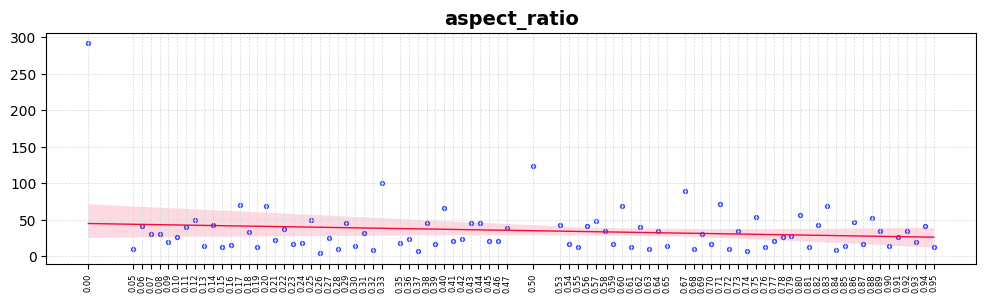

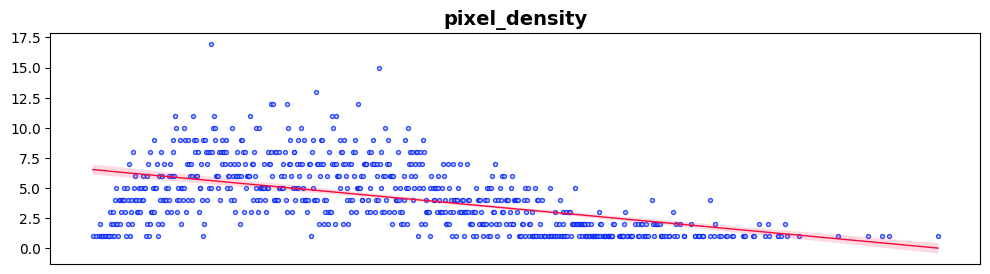

In [14]:
# отрисуем соотношения сторон и плотность пикселей на графиках:

for i in range(-2, 0):
    spam = rdd.map(lambda x: (x[i], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[0], ascending=True).collect()

    x, y = zip(*spam)

    plt.figure(figsize=(12, 3))
    sns.regplot(x=list(x), y=list(y), scatter_kws={'s': 8, 'color': '#BFC8FF', 
                                                   'edgecolors': '#0425FA'}, 
                line_kws={'lw': 1, 'color': '#F7093B'})
    
    plt.title(header[i], fontsize=14, fontweight='bold')
    if len(x) < 100:
        plt.grid(linewidth=.5, linestyle='--', c='#D6DBDF')
        plt.xticks(x, rotation=90, fontsize=6)
    else:
       plt.xticks([]);

In [15]:
# а с помощью функции get_top_ten мы сможем получить топ-10 любого столбца

def get_top_ten(rdd, header, name_column):
    """функция для нахождения ТОП любого столбца"""
    column_index = header.index(name_column)

    top_ten = rdd.map(lambda x: (x[column_index], 1)) \
                              .filter(lambda x: x[0] != 0.0) \
                              .reduceByKey(lambda x, y: x + y) \
                              .sortBy(lambda x: x[1], ascending=False) \
                              .takeOrdered(10, key=lambda x: -x[1])

    print(f'Топ-10 по {name_column}:')
    num = 1
    for elem, count in top_ten:
        print(f'{num}) Значение: {elem}, Количество телефонов: {count}')
        num += 1

# получим ТОП-10 по плотности пикселей и соотношению сторон:
for i in ['pixel_density', 'aspect_ratio']:
    get_top_ten(rdd, header, i)
    print()

Топ-10 по pixel_density:
1) Значение: 256.0, Количество телефонов: 17
2) Значение: 469.0, Количество телефонов: 15
3) Значение: 389.0, Количество телефонов: 13
4) Значение: 352.0, Количество телефонов: 12
5) Значение: 332.0, Количество телефонов: 12
6) Значение: 335.0, Количество телефонов: 12
7) Значение: 443.0, Количество телефонов: 12
8) Значение: 260.0, Количество телефонов: 11
9) Значение: 410.0, Количество телефонов: 11
10) Значение: 234.0, Количество телефонов: 11

Топ-10 по aspect_ratio:
1) Значение: 0.5, Количество телефонов: 123
2) Значение: 0.33, Количество телефонов: 100
3) Значение: 0.67, Количество телефонов: 89
4) Значение: 0.71, Количество телефонов: 71
5) Значение: 0.17, Количество телефонов: 70
6) Значение: 0.83, Количество телефонов: 69
7) Значение: 0.2, Количество телефонов: 68
8) Значение: 0.6, Количество телефонов: 68
9) Значение: 0.4, Количество телефонов: 66
10) Значение: 0.8, Количество телефонов: 56



# JOIN
Повторите вышеописанное задание с помощью одной из функций ниже (отдельно рассчитайте для train и test, затем объедините результат)

Пример для двух RDDs: (rdd = {(1, 2), (3, 4), (3, 6)} other = {(3, 9)})

Имя функции |	Purpose |	Example |	Result
------------- |	------- |	------- |	------
subtractByKey |Remove elements with a key present in the other RDD.| rdd.subtractByKey(other) | {(1, 2)}
join | Perform an inner join between two RDDs. | rdd.join(other) | {(3, (4, 9)), (3, (6, 9))}
rightOuterJoin | Perform a join between two RDDs where the key must be present in the first RDD. | rdd.rightOuterJoin(other) | {(3,(Some(4),9)), (3,(Some(6),9))}leftOuterJoin | Perform a join between two RDDs where the key must be present in the other RDD. | rdd.
leftOuterJoin(other) | {(1,(2,None)), (3,(4,Some(9))), (3,(6,Some(9)))}
cogroup | Group data from both RDDs sharing the same key. | rdd.cogroup(other) | {(1,([2],[])), (3,([4, 6],[9]))}


In [16]:
# Задание 6
# Рассчитайте для train и test, затем объедините результат

# Решение
# Напомним себе, что лежит в train и test:

beautiful_print(train, 3, train_header, line_break=8)
get_size(train, train_header, 'train')
print('___'*50, '\n')
beautiful_print(test, 3, test_header, line_break=8)
get_size(test, test_header, 'test')

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, 

	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0]
train size: 2000 x 1
______________________________________________________________________________________________________________________________________________________ 

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, 

	 [1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 

In [17]:
# количество столбцов одинаковое, так что можем использовать индексы train_header и для train и для test

sc_h_ = train_header.index('sc_h')
sc_w_ = train_header.index('sc_w')
px_height_ = train_header.index('px_height')
px_width_ = train_header.index('px_width')

train_with_new_cols = train.map(lambda x: (*x, add_ratio(x[sc_w_], x[sc_h_]))) \
    .map(lambda x: (*x, add_pixel_density(x[px_width_], x[px_height_], x[sc_h_], x[sc_w_])))

test_with_new_cols = test.map(lambda x: (*x, add_ratio(x[sc_w_], x[sc_h_]))) \
    .map(lambda x: (*x, add_pixel_density(x[px_width_], x[px_height_], x[sc_h_], x[sc_w_])))

new_header = header + ['aspect_ratio', 'pixel_density']

rdd_with_new_cols = sc.union([train_with_new_cols, test_with_new_cols])

beautiful_print(rdd_with_new_cols, 3, new_header, line_break=8)
get_size(rdd_with_new_cols, new_header, 'rdd_with_new_cols')

battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, 
mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, 
talk_time, three_g, touch_screen, wifi, aspect_ratio, pixel_density, aspect_ratio, pixel_density, 

	 (842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0, 0.78, 224.0)
	 (1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0, 0.18, 526.0)
	 (563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0, 0.18, 637.0)
rdd_with_new_cols size: 3000 x 1


In [18]:
# получим ТОП-10 по плотности пикселей и соотношению сторон:
for i in ['pixel_density', 'aspect_ratio']:
    get_top_ten(rdd_with_new_cols, header, i)
    print()

Топ-10 по pixel_density:
1) Значение: 256.0, Количество телефонов: 17
2) Значение: 469.0, Количество телефонов: 15
3) Значение: 389.0, Количество телефонов: 13
4) Значение: 352.0, Количество телефонов: 12
5) Значение: 332.0, Количество телефонов: 12
6) Значение: 335.0, Количество телефонов: 12
7) Значение: 443.0, Количество телефонов: 12
8) Значение: 260.0, Количество телефонов: 11
9) Значение: 410.0, Количество телефонов: 11
10) Значение: 234.0, Количество телефонов: 11

Топ-10 по aspect_ratio:
1) Значение: 0.5, Количество телефонов: 123
2) Значение: 0.33, Количество телефонов: 100
3) Значение: 0.67, Количество телефонов: 89
4) Значение: 0.71, Количество телефонов: 71
5) Значение: 0.17, Количество телефонов: 70
6) Значение: 0.83, Количество телефонов: 69
7) Значение: 0.2, Количество телефонов: 68
8) Значение: 0.6, Количество телефонов: 68
9) Значение: 0.4, Количество телефонов: 66
10) Значение: 0.8, Количество телефонов: 56



P.S.: join и пр. применять не стал, так как он объединяет таблицы по ключу, в моём решении в качестве ключа выступило бы какое-то цифровое значение, которое присутствует и в train и в test, а значением стал бы кортеж, содержащий значения для такого ключа и в train и в test, т.е. это было бы что-то для нас неинформативное, типа такого:

In [19]:
train_with_new_cols.join(test_with_new_cols).take(5)

[(1520.0, (1.0, 0.0)),
 (1520.0, (0.0, 0.0)),
 (1568.0, (1.0, 0.0)),
 (644.0, (1.0, 1.0)),
 (644.0, (1.0, 1.0))]

In [20]:
train_with_new_cols.cogroup(test_with_new_cols).take(5)

[(1520.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f500e884790>,
   <pyspark.resultiterable.ResultIterable at 0x7f500bb0d8d0>)),
 (772.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f500bb0c1f0>,
   <pyspark.resultiterable.ResultIterable at 0x7f500bb0ddb0>)),
 (956.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f500bb0e770>,
   <pyspark.resultiterable.ResultIterable at 0x7f500bb0e680>)),
 (1568.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f500bb0e7a0>,
   <pyspark.resultiterable.ResultIterable at 0x7f500bb0eb60>)),
 (644.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f500bb0ece0>,
   <pyspark.resultiterable.ResultIterable at 0x7f500bb0ebf0>))]